In [1]:
run_gridsearch = False
skip_best_model_validation = True
skip_best_model_test = True
testEnsembles = 5
gpuSetting = 0
hyperparam_csv_file = "hopland_daily_hyperparams.csv"

In [2]:
import sys
import os
import itertools
current_dir = os.getcwd()
print(current_dir)

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all


In [3]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-LSTMs', 'F:\\Dino\\UCB-USACE-LSTMs\\UCB_training\\models\\hopland_all', 'C:\\Users\\Dino\\anaconda3\\python312.zip', 'C:\\Users\\Dino\\anaconda3\\DLLs', 'C:\\Users\\Dino\\anaconda3\\Lib', 'C:\\Users\\Dino\\anaconda3', '', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\Pythonwin']


In [4]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import combinedPlot
from UCB_training.UCB_utils import fancyCombinedPlot
from UCB_training.UCB_utils import combinedPlotFromDf
from UCB_training.UCB_utils import fancyCombinedPlotFromDf

In [5]:
# Dynamically find the repo root from the current working directory
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

# Construct the target path
target_path = os.path.join(library_path, 'UCB_training', 'models', 'hopland_all')

# Verify if the directory exists before changing
if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("hopland")) #each basin has its own train basin file, so change for different basins e.g "guerneville", etc.
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all
Train Basin File Exists: True


In [6]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("hopland_gage_nlayers.yaml") #update the yaml file for different basins
path_to_physics_data = Path(library_path + "/russian_river_data/Hopland_daily.csv")

In [7]:
features_with_physics = [
    #from daily.csv
    "RUSSIAN 60 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "RUSSIAN 60 PRECIP-INC SCREENED",
    "RUSSIAN 70 PRECIP-INC SCREENED",
    "RUSSIAN 70 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "WF RUSSIAN PRECIP-INC SCREENED",
    "WF RUSSIAN ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    #from hopland.csv
    'Hopland Gage FLOW',
    'Russian 60 ET-POTENTIAL',
    'Russian 60 FLOW',
    'Russian 60 FLOW-BASE',
    'Russian 60 INFILTRATION',
    'Russian 60 PERC-SOIL',
    'Russian 60 SATURATION FRACTION',
    'Russian 70 ET-POTENTIAL',
    'Russian 70 FLOW',
    'Russian 70 FLOW-BASE',
    'Russian 70 INFILTRATION',
    'Russian 70 PERC-SOIL',
    'Russian 70 SATURATION FRACTION',
    'WF Russian ET-POTENTIAL',
    'WF Russian FLOW',
    'WF Russian FLOW-BASE',
    'WF Russian INFILTRATION',
    'WF Russian PERC-SOIL',
    'WF Russian SATURATION FRACTION',
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "UKIAH CA FLOW USGS-MERGED",
    #"Lake Mendocino Storage",    
]

In [8]:
hyperparam_space = {
    "hidden_size": [128, 256],
    "seq_length": [90, 180],
    "num_layers": [1, 2],
    "epochs": [16, 32]
}
fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [9]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):
        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
        }
        print(f"NoPhysics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,
            extend_train_period=False,
            gpu=gpuSetting
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        row_data = {"hidden_size": hs, "seq_length": seq, "num_layers": nl, "epochs": ep, "output_dropout": fixed_dropout}
        for k, v in metrics_dict.items():
            row_data[k] = v
        no_physics_results.append(row_data)
    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping Grid-Search")

Skipping Grid-Search


In [10]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"]
    ):
        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
        }
        print(f"Physics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=gpuSetting
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        row_data = {"hidden_size": hs, "seq_length": seq, "num_layers": nl, "epochs": ep, "output_dropout": fixed_dropout}
        for k, v in metrics_dict.items():
            row_data[k] = v
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping Grid-Search")

Skipping Grid-Search


In [11]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": int(best_no_phys["seq_length"]),
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"]),
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": int(best_phys["seq_length"]),
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"]),
    }

In [12]:
if run_gridsearch:
    print(df_no_physics.iloc[0:9])
    df_no_physics.to_csv("hopland_daily_no_physics_gridsearch.csv", index=False)

In [13]:
if run_gridsearch:
    print(df_physics.iloc[0:9])
    df_physics.to_csv("hopland_daily_physics_gridsearch.csv", index=False)

# Re-run validation with the best hyperparameters

In [15]:
if not skip_best_model_validation:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=gpuSetting
    )
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [16]:
if not skip_best_model_validation:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=gpuSetting
    )
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future ver

[INFO] Wrote metrics CSV: hopland_daily_val_metrics.csv


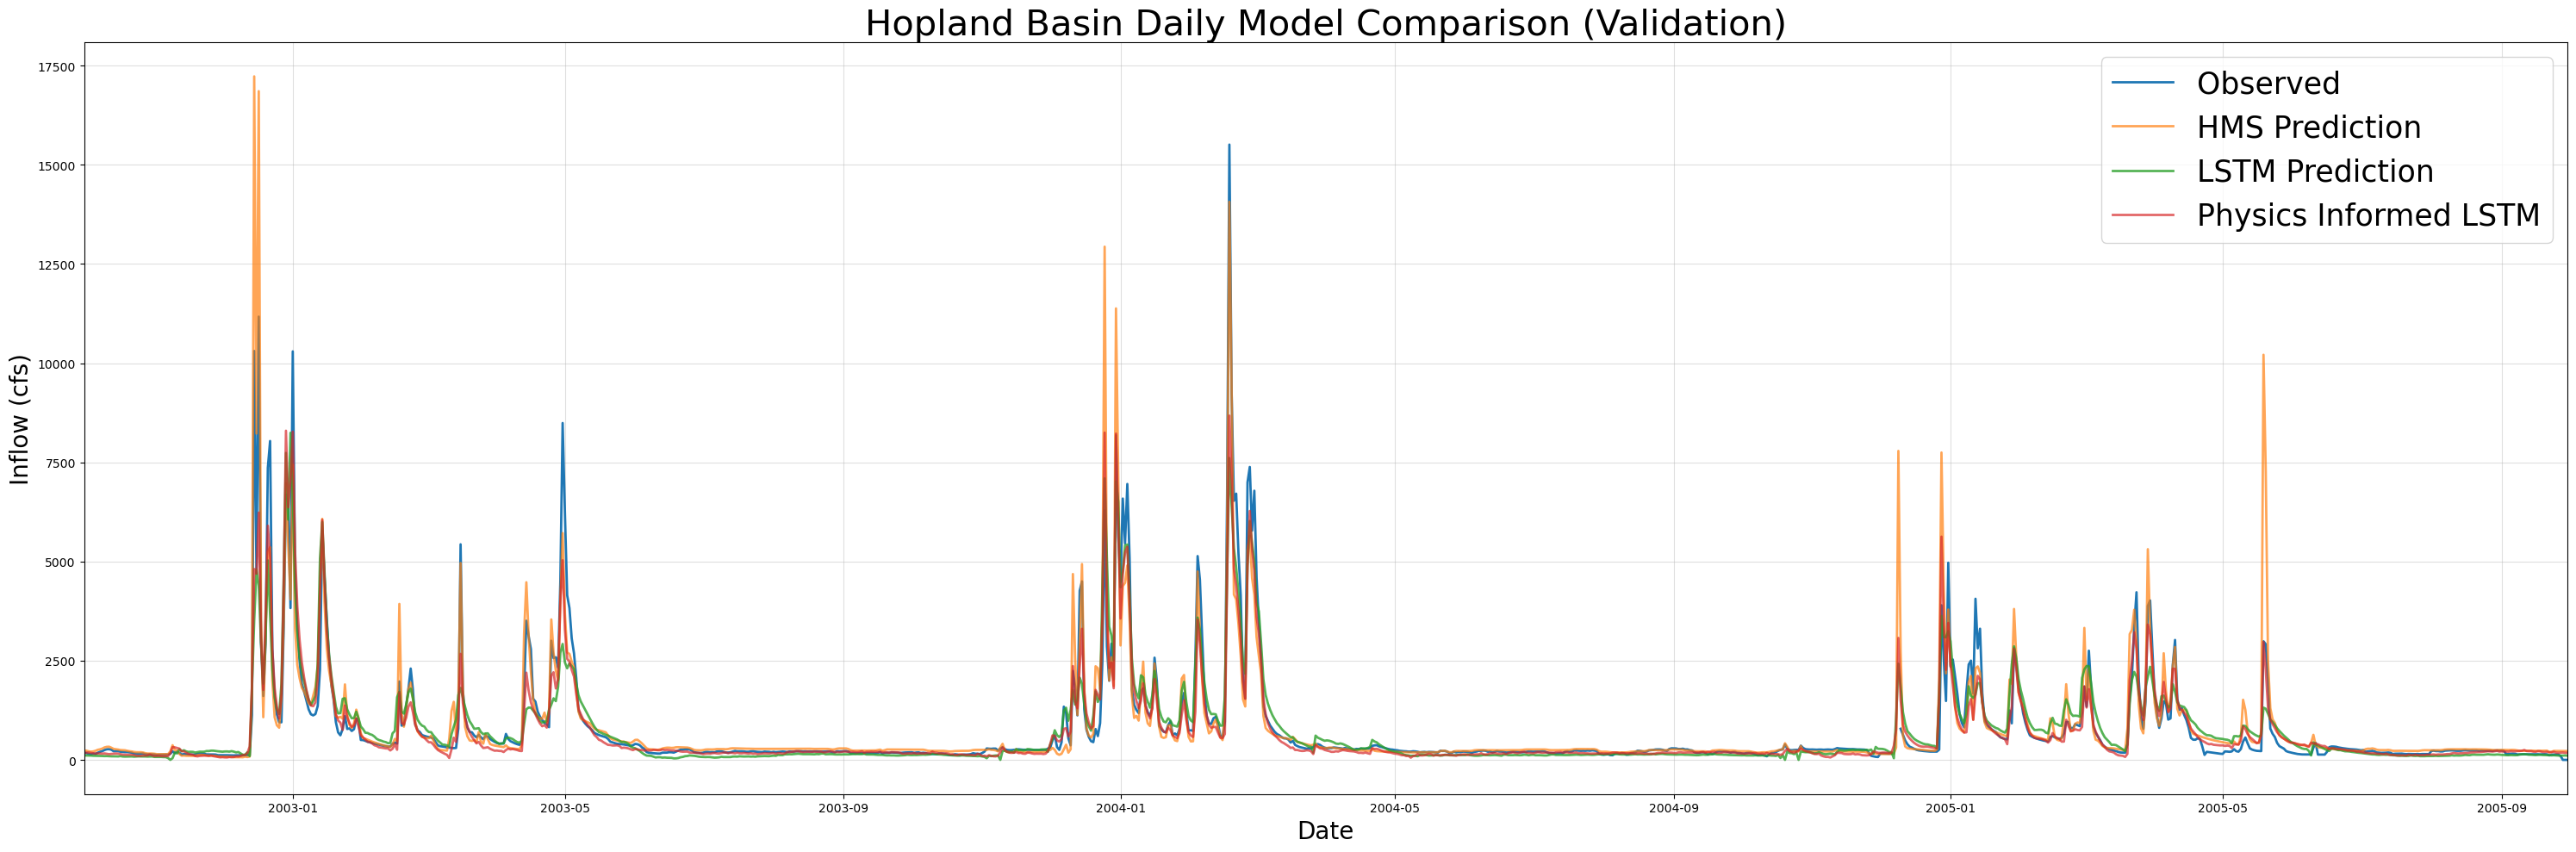

In [17]:
if not skip_best_model_validation:
    combinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title="Hopland Basin Daily Model Comparison (Validation)",
        fName="hopland_daily_val_metrics.csv",
        plot_filename="hopland_daily_val_model_comparison.png",
        timeseries_filename ="hopland_daily_val_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("hopland_daily_val_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Validation)", fName="hopland_daily_val_metrics.csv")

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future ver

[INFO] Wrote metrics CSV: hopland_daily_val_metrics.csv


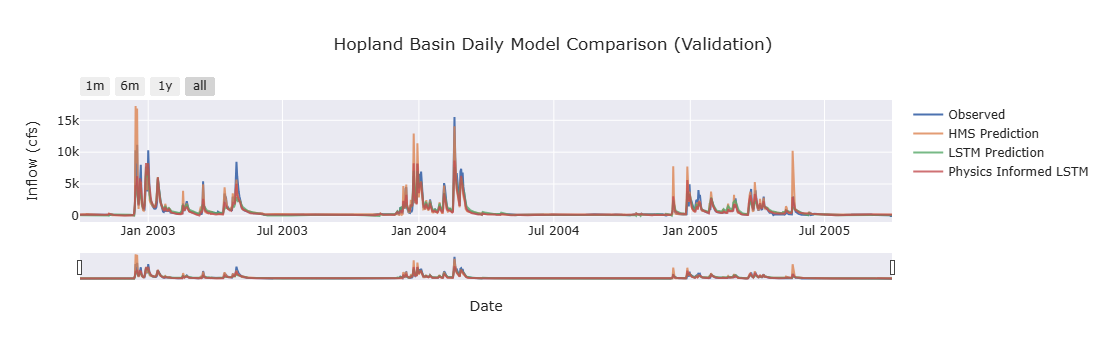

In [18]:
if not skip_best_model_validation:
    fancyCombinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title='Hopland Basin Daily Model Comparison (Validation)',
        fName="hopland_daily_val_metrics.csv", 
        timeseries_filename ="hopland_daily_val_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Validation)", fName="hopland_daily_val_metrics.csv")

In [19]:
if skip_best_model_validation:
    val_metrics = pd.read_csv("hopland_daily_val_metrics.csv", index_col=0)
    print(val_metrics)

                       HMS           LSTM  Physics_Informed_LSTM
NSE               0.797363       0.782802               0.864474
MSE          389482.337520  417470.650472          260490.950215
RMSE            624.085201     646.119687             510.383141
KGE               0.875456       0.759691               0.780278
Alpha-NSE         1.062098       0.791024               0.815864
Beta-KGE          1.054547       0.953802               0.896403
Beta-NSE          0.029693      -0.025148              -0.056393
Pearson-r         0.906836       0.890714               0.939671
FHV               6.805003     -24.524448             -20.216368
FMS              -5.549918      55.606270              13.479237
FLV              94.270876       2.592815              94.324363
Peak-Timing       0.000000       0.400000               0.200000
Peak-MAPE        24.485549      51.036107              36.729816
PBIAS            -5.454718       4.619838              10.359715


# Re-run testing with the best hyperparameters

In [21]:
if not skip_best_model_test:
    hoplandNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True, 
        num_ensemble_members = testEnsembles,
        gpu=gpuSetting
    )
    
    hoplandNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = hoplandNoPhysicsExtBest.results('test')
    no_physics_test_metrics

In [22]:
if not skip_best_model_test:
    hoplandPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,  
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        num_ensemble_members = testEnsembles,
        gpu=gpuSetting
    )
    
    hoplandPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = hoplandPhysicsExtBest.results('test')
    physics_test_metrics

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neural

[INFO] Wrote metrics CSV: hopland_daily_test_metrics.csv


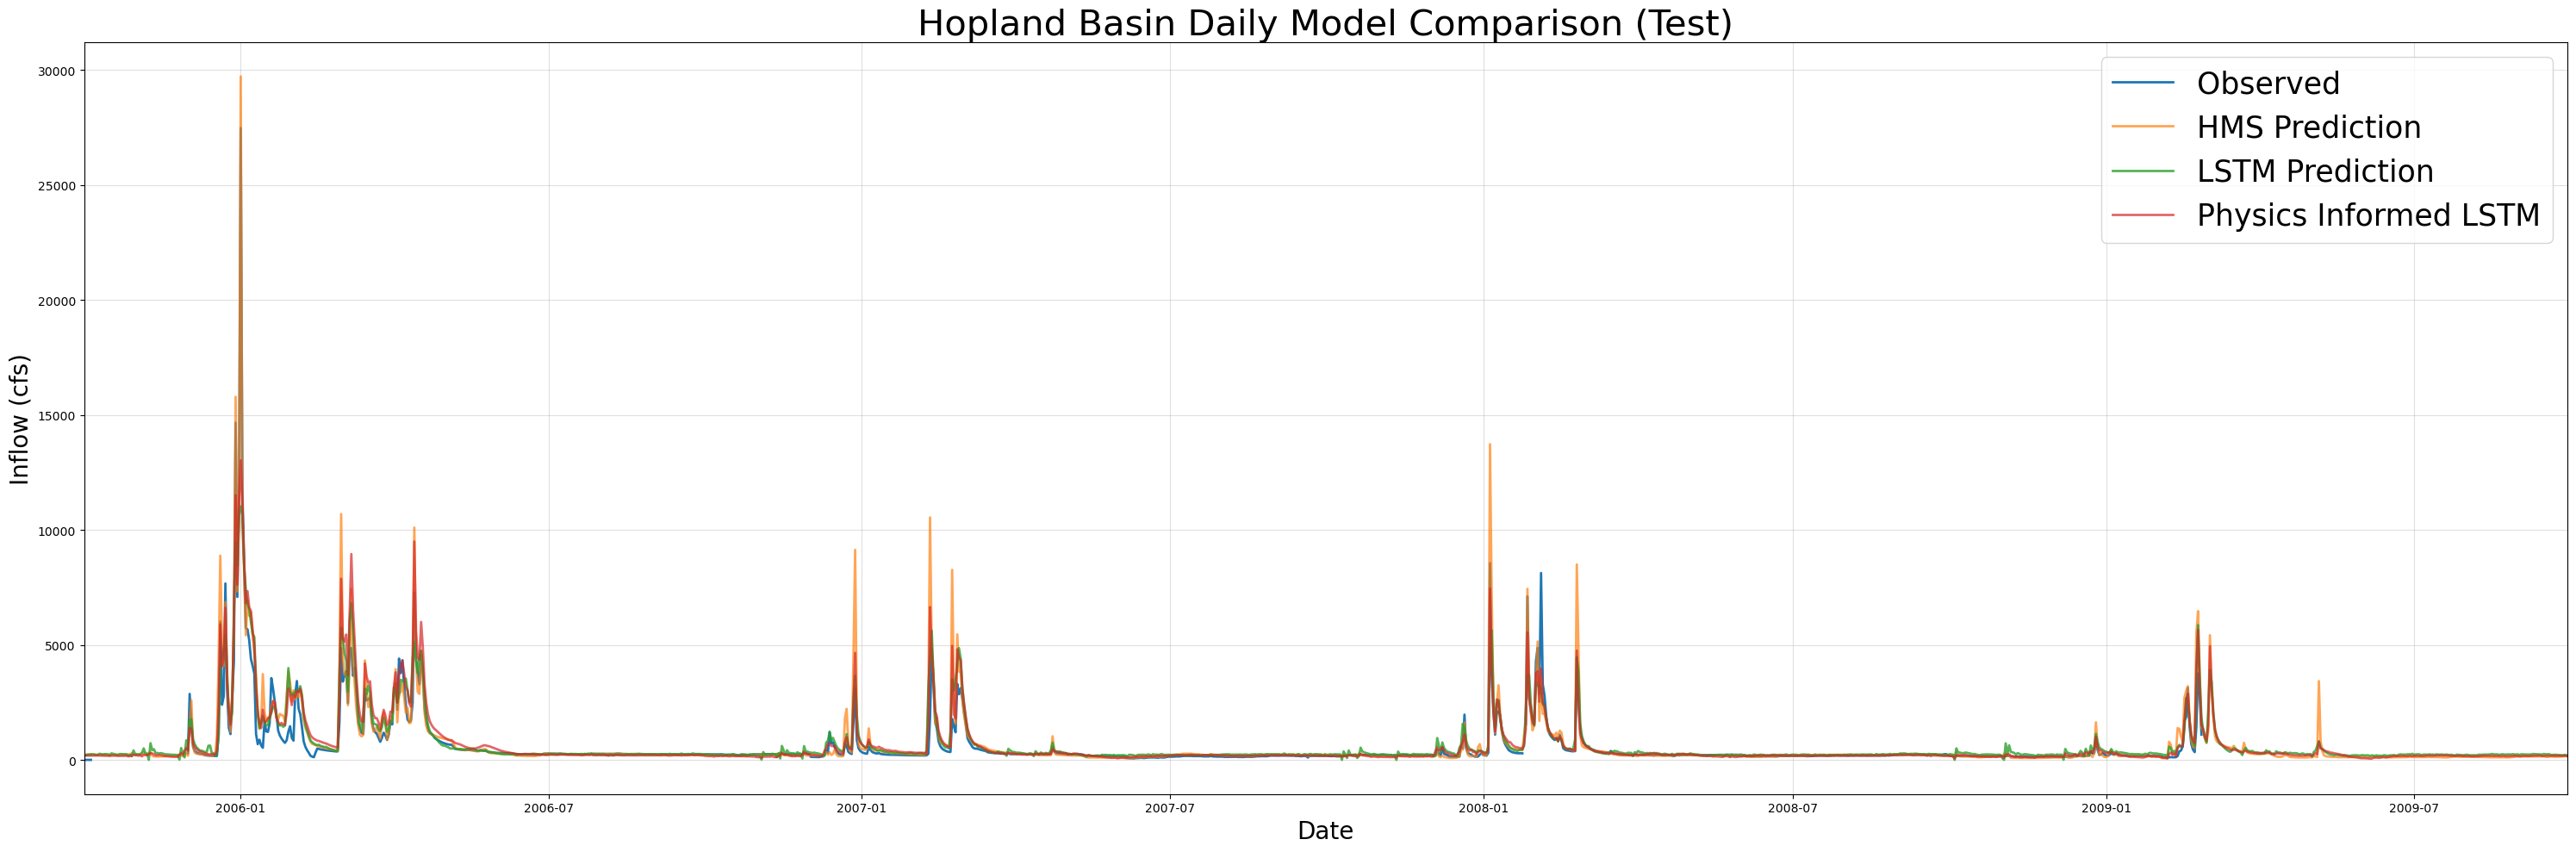

In [23]:
if not skip_best_model_test:
    combinedPlot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Hopland Basin Daily Model Comparison (Test)",
        fName="hopland_daily_test_metrics.csv",
        plot_filename="hopland_daily_test_model_comparison.png", 
        timeseries_filename ="hopland_daily_test_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("hopland_daily_test_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Test)", fName="hopland_daily_test_metrics.csv")

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\hopland_all\..\..\..\..\UCB-USACE-LSTMs\neural

[INFO] Wrote metrics CSV: hopland_daily_test_metrics.csv


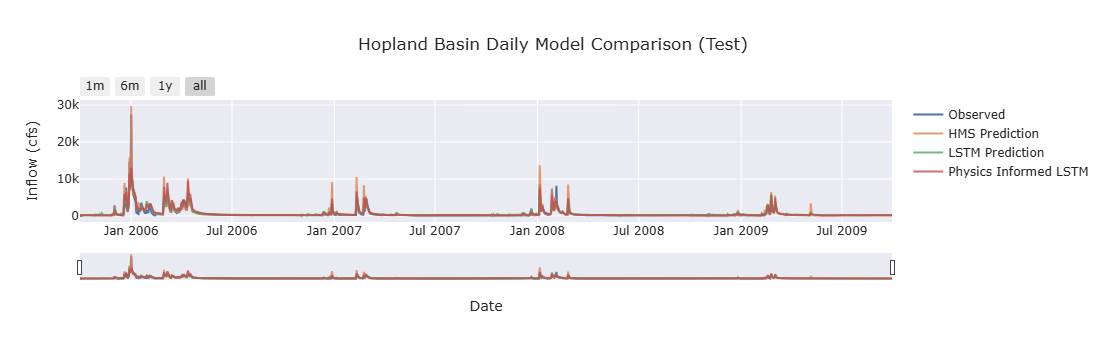

In [24]:
if not skip_best_model_test:
    fancyCombinedPlot(lstm_results=no_physics_test_csv, lstmPhysics_results= physics_test_csv, HMS_results=path_to_physics_data, title='Hopland Basin Daily Model Comparison', fName = "hopland_daily_test_metrics.csv", timeseries_filename ="hopland_daily_test_combined_ts.csv")
else:
    fancyCombinedPlotFromDf(combined_df, title="Hopland Basin Daily Model Comparison (Test)", fName="hopland_daily_test_metrics.csv")

In [25]:
test_metrics = pd.read_csv("hopland_daily_test_metrics.csv", index_col=0)
print(test_metrics)

                       HMS           LSTM  Physics_Informed_LSTM
NSE               0.795548       0.766148               0.803130
MSE          404643.883879  462830.388053          389637.997748
RMSE            636.116250     680.316388             624.209899
KGE               0.728187       0.755197               0.798612
Alpha-NSE         1.186227       0.876955               0.972859
Beta-KGE          1.185632       1.173264               1.173873
Beta-NSE          0.079942       0.074616               0.074878
Pearson-r         0.931134       0.878475               0.902079
FHV              23.945896     -10.381237               0.799319
FMS              30.814334      15.372918              47.249120
FLV              96.352301      -1.866173              95.037950
Peak-Timing       0.250000       0.250000               0.250000
Peak-MAPE        36.378148      41.052414              30.180220
PBIAS           -18.563180     -17.326353             -17.387331
